Version: 02.14.2023

# Lab 4.1: Implementing Sentiment Analysis
 


In this lab, you will develop a solution to perform sentiment analysis on the Internet Movie Database (IMDB) dataset.

## Learning objectives

- Evaluate machine learning (ML) algorithms that are used in natural language processing (NLP) for sentiment analysis
- Create a solution to a sentiment analysis business problem.

## Introducing the business scenario

In this lab, you will play the role of a data scientist on a small development team. The organization that you work for maintains a website of movie reviews. A key customer feature was identified: to provide an overall *Smiley Face* (positive inference) or *Sad Face* (negative inference) for a particular movie based on the number of its positive and negative reviews. You will develop an ML solution that developers can use to create an inference for a movie review. You will need to analyze the review and indicate if it is positive or negative.

To help with this task, you have access to a dataset that contains the raw text of 50,000 movie reviews. These reviews have been labeled either as positive or negative.

About this dataset
The Large Movie Review Dataset is a collection of highly polar movie reviews. This data supports work in the following paper:

Andrew L. Maas, Raymond E. Daly, Peter T. Pham, Dan Huang, Andrew Y. Ng, and Christopher Potts. "Learning Word Vectors for Sentiment Analysis." Presented at the 49th Annual Meeting of the Association for Computational Linguistics (ACL 2011), Portland, Oregon, USA, June 2011. http://ai.stanford.edu/~amaas/data/sentiment/.

The dataset contains a single text field containing the review. The dataset is labeled either positive (1) or negative (0).

The dataset contains the following features:

text: Text of the review
label: Whether the review is positive or negative (1 or 0)

## Lab steps

To complete this lab, you will follow these steps:

1. [Installing packages](#1.-Installing-packages)
2. [Reading the dataset](#2.-Reading-the-dataset)
3. [Performing exploratory data analysis](#3.-Performing-exploratory-data-analysis)
4. [Running the first pass: Minimal processing](#4.-Running-the-first-pass:-Minimal-processing)
5. [Running the second pass: Normalizing the text](#5.-Running-the-second-pass:-Normalizing-the-text)
6. [Tuning hyperparameters](#6.-Tuning-hyperparameters)
7. [Using BlazingText](#7.-Using-BlazingText)
8. [Using-Amazon Comprehend](#8.-Using-Amazon-Comprehend)

## Submitting your work

1. In the lab console, choose **Submit** to record your progress and when prompted, choose **Yes**.

1. If the results don't display after a couple of minutes, return to the top of the lab instructions and choose **Grades**.

**Tip:** You can submit your work multiple times. After you change your work, choose **Submit** again. Your last submission is what will be recorded for this lab.

1. To find detailed feedback on your work, choose **Details** followed by **View Submission Report**.

## 1. Installing packages
([Go to top](#Lab-4.1:-Implementing-Sentiment-Analysis))

Start by updating and installing the packages that you will use in the notebook. 


In [1]:
#Install/Upgrade dependencies
!pip install --upgrade pip
!pip install --upgrade boto3
!pip install --upgrade scikit-learn
!pip install --upgrade sagemaker
!pip install --upgrade nltk
!pip install --upgrade seaborn

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com


__Note:__ Before you proceed with this lab for the first time, we recommend that you restart the kernel by choosing __Kernel__ > __Restart Kernel__.

Import the packages that are used in the notebook.

In [2]:
import boto3
import os, io, struct
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score, roc_curve, auc, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /home/ec2-user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /home/ec2-user/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

The following code cell includes a few helper functions that  plot a confusion matrix and calculate other key metrics.

In [3]:

def plot_confusion_matrix(test_labels, target_predicted):
    matrix = confusion_matrix(test_labels, target_predicted)
    df_confusion = pd.DataFrame(matrix)
    colormap = sns.color_palette("BrBG", 10)
    sns.heatmap(df_confusion, annot=True, fmt='.2f', cbar=None, cmap=colormap)
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.ylabel("True Class")
    plt.xlabel("Predicted Class")
    plt.show()
    
def print_metrics(test_labels, target_predicted_binary):
    TN, FP, FN, TP = confusion_matrix(test_labels, target_predicted_binary).ravel()
    # Sensitivity, hit rate, recall, or true positive rate
    Sensitivity  = float(TP)/(TP+FN)*100
    # Specificity or true negative rate
    Specificity  = float(TN)/(TN+FP)*100
    # Precision or positive predictive value
    Precision = float(TP)/(TP+FP)*100
    # Negative predictive value
    NPV = float(TN)/(TN+FN)*100
    # Fall out or false positive rate
    FPR = float(FP)/(FP+TN)*100
    # False negative rate
    FNR = float(FN)/(TP+FN)*100
    # False discovery rate
    FDR = float(FP)/(TP+FP)*100
    # Overall accuracy
    ACC = float(TP+TN)/(TP+FP+FN+TN)*100

    print(f"Sensitivity or TPR: {Sensitivity}%")    
    print(f"Specificity or TNR: {Specificity}%") 
    print(f"Precision: {Precision}%")   
    print(f"Negative Predictive Value: {NPV}%")  
    print( f"False Positive Rate: {FPR}%") 
    print(f"False Negative Rate: {FNR}%")  
    print(f"False Discovery Rate: {FDR}%" )
    print(f"Accuracy: {ACC}%") 



## 2. Reading the dataset

([Go to top](#Lab-4.1:-Implementing-Sentiment-Analysis))

In this section, you will load the dataset. The dataset has already been downloaded by Amazon Sagemaker Studio. Use the __pandas__ library to read the dataset.

#### __Loading the training data:__

In [4]:
df = pd.read_csv('../data/imdb.csv', header=0)

## 3. Performing exploratory data analysis
([Go to top](#Lab-4.1:-Implementing-Sentiment-Analysis))

In this section, you will examine the dataset. 

Complete the following functions. The first one has been provided so that you can learn the format.


### Challenge: Listing the first eight rows

In [5]:
def show_eight_rows(df):
    # Implement this function
    return df.head(8)    

In [6]:
print(show_eight_rows(df))

                                                text  label
0  What I hoped for (or even expected) was the we...      0
1  Garden State must rate amongst the most contri...      0
2  There is a lot wrong with this film. I will no...      1
3  To qualify my use of "realistic" in the summar...      1
4  Dirty War is absolutely one of the best politi...      1
5  Many other viewers are saying that this is not...      1
6  I understand that Roger Corman loves to do thi...      0
7  I love this show. I watched every episode last...      0


### Challenge: What is the shape of the data?

In [7]:
def show_data_shape(df):
    # Implement this function
    ### BEGIN_SOLUTION
    return df.shape
    ### END_SOLUTION

In [8]:
print(show_data_shape(df))

(50000, 2)


### Challenge: How many positive and negative instances are in the data?

In [9]:
def show_data_instances(df):
    # Implement this function
    ### BEGIN_SOLUTION
    return df['label'].value_counts()
    ### END_SOLUTION

In [10]:
print(show_data_instances(df))

0    25000
1    25000
Name: label, dtype: int64


### Challenge: Does the data have any missing values?

In [11]:
def show_missing_values(df):
    # Implement this function
    ### BEGIN_SOLUTION
    return df.isna().sum()
    ### END_SOLUTION
    

In [12]:
print(show_missing_values(df))

text     0
label    0
dtype: int64


## 4. Running the first pass: Minimal processing
([Go to top](#Lab-4.1:-Implementing-Sentiment-Analysis))

In this section, you will perform the minimum steps that are needed to train a classification model. You will use this trained model to see the impact of processing text on the results.

Start by importing the Natural Langauge ToolKit (NLTK) package and the Regular Expression (re) package.

In [13]:
import nltk, re
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize

### Challenge: Splitting the data into datasets for training, validation, and testing

In this task, you will split the dataset so that you have 80 percent of the dataset for training, and 10 percent each for validation and testing.

To split the dataset, use the `train_test_split` function from __scikit-learn__. For more information about this function, see the [scikit-learn test_train_split documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) at https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html.

Specify __df__ as the dataset. Split this dataset into a __train__ set and a __test_and_validate__ set. Then, split the __train_and_validate__ set into the __test__ set and the __validate__ set.

(*Optional*) For repeatable results, shuffle the deck and **random_state**.

In [14]:
from sklearn.model_selection import train_test_split
# uncomment the following lines and implement your solution
def split_data(df):
    # train, test_and_validate = train_test_split(....)
    # test, validate = train_test_split(....)
    ### BEGIN_SOLUTION
    train, test_and_validate = train_test_split(df,
                                            test_size=0.2,
                                            shuffle=True,
                                            random_state=324
                                            )
    test, validate = train_test_split(test_and_validate,
                                                test_size=0.5,
                                                shuffle=True,
                                                random_state=324)
    ### END_SOLUTION
    return train, validate, test

Check whether your datasets are split correctly by running the following code cell.

In [15]:
train, validate, test = split_data(df)
print(train.shape)
print(test.shape)
print(validate.shape)

(40000, 2)
(5000, 2)
(5000, 2)


### Assembling the processing pipeline

In this cell, the basic processing pipeline is assembled for the text data. You will now modify this implementation to add more features.

In [16]:
%%time

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

text_features = ['text']
model_target = 'label'

text_processor_0 = Pipeline([
    ('text_vect_0', CountVectorizer(max_features=500))
])

data_preprocessor = ColumnTransformer([
    ('text_pre_0', text_processor_0, text_features[0])
])

print('Datasets shapes before processing: ', train.shape, validate.shape, test.shape)
train_matrix = data_preprocessor.fit_transform(train)
test_matrix = data_preprocessor.transform(test)
validate_matrix = data_preprocessor.transform(validate)
print('Datasets shapes after processing: ', train_matrix.shape, validate_matrix.shape, test_matrix.shape)

Datasets shapes before processing:  (40000, 2) (5000, 2) (5000, 2)
Datasets shapes after processing:  (40000, 500) (5000, 500) (5000, 500)
CPU times: user 7.32 s, sys: 89.9 ms, total: 7.41 s
Wall time: 7.41 s


To train a model, the data must be uploaded to Amazon Simple Storage Service (Amazon S3) in the correct format. XGBoost uses a comma-separated values (CSV) file.

In [17]:
s3_resource = boto3.Session().resource('s3')

def upload_s3_csv(filename, folder, X_train, y_train, is_test=False):
    csv_buffer = io.StringIO()
    features = [t.toarray().astype('float32').flatten().tolist() for t in X_train]
    if is_test:
        temp_list = features
    else:
        temp_list = np.insert(features, 0, y_train['label'], axis=1)
    np.savetxt(csv_buffer, temp_list, delimiter=',' )
    s3_resource.Bucket(bucket).Object(os.path.join(prefix, folder, filename)).put(Body=csv_buffer.getvalue())

In [18]:
bucket = 'c73485a1491087l3681508t1w420634201050-labbucket-gh2i9k2ayp1'

Set the file names for this pass.

In [19]:
prefix='lab41'
train_file='train-pass1.csv'
validate_file='validate-pass1.csv'
test_file='test-pass1.csv'

Upload the train, validate, and test datasets to Amazon S3.

In [20]:
upload_s3_csv(train_file, 'train', train_matrix, train)
upload_s3_csv(validate_file, 'validate', validate_matrix, validate)
upload_s3_csv(test_file, 'test', test_matrix, test, True)

### Challenge: Training an XGBoost model

Uncomment and complete the following SageMaker function to create an `Estimator`. Use the following parameters:
- **role**: Use the current SageMaker role (__Hint:__ Use `sagemaker.get_execution_role()`)
- **instance count**: `1`
- **instance type**: `ml.m5.xlarge`


In [21]:
import sagemaker
from sagemaker.image_uris import retrieve
container = retrieve('xgboost',boto3.Session().region_name,'1.0-1')
s3_output_location=f's3://{bucket}/{prefix}/output/'

hyperparams={"num_round":"42",
             "eval_metric": "error",
             "objective": "binary:logistic",
             "silent" : 1}

# xgb_model=sagemaker.estimator.Estimator(container,
#                                         role=<INSERT_ROLE_HERE>,
#                                         instance_count=<INSERT_COUNT_HERE>,
#                                         instance_type=<INSERT_INSTANCE_TYPE_HERE>,
#                                         output_path=s3_output_location,
#                                         hyperparameters=hyperparams,
#                                         sagemaker_session=sagemaker.Session())
### BEGIN_SOLUTION
xgb_model=sagemaker.estimator.Estimator(container,
                                        role=sagemaker.get_execution_role(),
                                        instance_count=1,
                                        instance_type='ml.m5.2xlarge',
                                        output_path=s3_output_location,
                                        hyperparameters=hyperparams,
                                        sagemaker_session=sagemaker.Session())
### END_SOLUTION

Set up the two data channels. One data channel is for the training data that's used to train the model. The second data channel is for the validation data that's used to generate performance metrics.

In [22]:
train_channel = sagemaker.inputs.TrainingInput(
    f's3://{bucket}/{prefix}/train/{train_file}',
    content_type='text/csv')

validate_channel = sagemaker.inputs.TrainingInput(
    f's3://{bucket}/{prefix}/validate/{validate_file}',
    content_type='text/csv')

data_channels = {'train': train_channel, 'validation': validate_channel}

Train the model. (This step might take a few minutes.)

In [23]:
%%time

xgb_model.fit(inputs=data_channels, logs=False, job_name='xgb-pass1-'+datetime.now().strftime("%m-%d-%Y-%H-%M-%S"))

INFO:sagemaker:Creating training-job with name: xgb-pass1-03-05-2023-06-47-50



2023-03-05 06:47:51 Starting - Starting the training job..
2023-03-05 06:48:06 Starting - Preparing the instances for training.......
2023-03-05 06:48:50 Downloading - Downloading input data....
2023-03-05 06:49:16 Training - Downloading the training image...
2023-03-05 06:49:31 Training - Training image download completed. Training in progress......
2023-03-05 06:50:02 Uploading - Uploading generated training model.
2023-03-05 06:50:13 Completed - Training job completed
CPU times: user 145 ms, sys: 2.12 ms, total: 147 ms
Wall time: 2min 26s


Display the metrics from the current XGBoost job.

In [24]:
sagemaker.analytics.TrainingJobAnalytics(xgb_model._current_job_name, 
                                         metric_names = ['train:error','validation:error']
                                        ).dataframe()

INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole


,timestamp,metric_name,value
0,0.0,train:error,0.20855
1,0.0,validation:error,0.23550


The initial results don't seem to be useful. Use the __test__ dataset to calculate more metrics. (This step might take a few minutes.)

In [25]:
%%time

upload_s3_csv('batch-in.csv', 'batch-in', test_matrix, test, True)
batch_X_file='batch-in.csv'
batch_output = f's3://{bucket}/{prefix}/batch-out/'
batch_input = f's3://{bucket}/{prefix}/batch-in/{batch_X_file}'

xgb_transformer = xgb_model.transformer(instance_count=1,
                                       instance_type='ml.m5.2xlarge',
                                       strategy='MultiRecord',
                                       assemble_with='Line',
                                       output_path=batch_output)

xgb_transformer.transform(data=batch_input,
                         data_type='S3Prefix',
                         content_type='text/csv',
                         split_type='Line',
                         job_name='xgboost-pass1')
xgb_transformer.wait(logs=False)

INFO:sagemaker:Creating model with name: sagemaker-xgboost-2023-03-05-06-50-19-537
INFO:sagemaker:Creating transform job with name: xgboost-pass1


ResourceInUse: An error occurred (ResourceInUse) when calling the CreateTransformJob operation: Job name must be unique within an AWS account and region, and a job with this name already exists (arn:aws:sagemaker:us-east-1:420634201050:transform-job/xgboost-pass1)

In [26]:
s3 = boto3.client('s3')
obj = s3.get_object(Bucket=bucket, Key=f'{prefix}/batch-out/batch-in.csv.out')
target_predicted = pd.read_csv(io.BytesIO(obj['Body'].read()),',',names=['class'])

def binary_convert(x):
    threshold = 0.5
    if x > threshold:
        return 1
    else:
        return 0

target_predicted_binary = target_predicted['class'].apply(binary_convert)


INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole
/tmp/ipykernel_20696/251496374.py:3: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only.
  target_predicted = pd.read_csv(io.BytesIO(obj['Body'].read()),',',names=['class'])


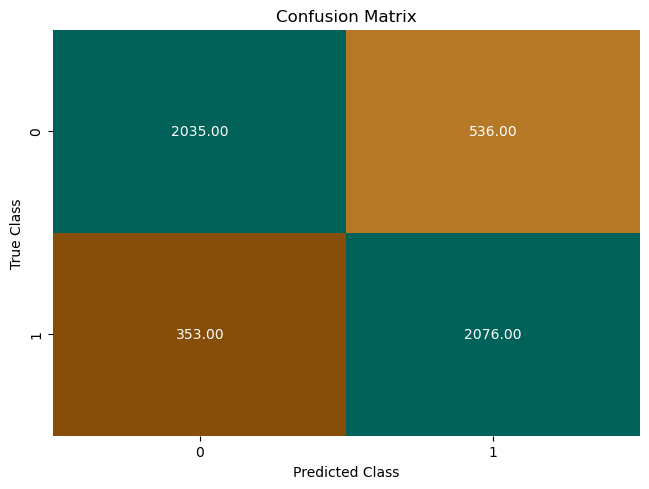

In [27]:
plot_confusion_matrix(test['label'], target_predicted_binary)

In [28]:
print_metrics(test['label'], target_predicted_binary)

Sensitivity or TPR: 85.4672704816797%
Specificity or TNR: 79.15208090237262%
Precision: 79.47932618683001%
Negative Predictive Value: 85.2177554438861%
False Positive Rate: 20.847919097627383%
False Negative Rate: 14.532729518320298%
False Discovery Rate: 20.520673813169985%
Accuracy: 82.22%


## 5. Second pass: Normalizing the text
([Go to top](#Lab-4.1:-Implementing-Sentiment-Analysis))

In this section, you will perform some standard preprocessing tasks on the text before you retrain the model.

### Challenge: Removing stopwords that might impact sentiment

You could remove all the stopwords, but you might want to keep the stopwords that could impact the sentiment, such as __not__ or __don't__. 

A few stopwords to exclude have been provided. Update the function to remove other words that might impact sentiment.

In [29]:
# Get a list of stopwords from the NLTK library
stop = stopwords.words('english')

def remove_stopwords(stopwords):
    # Implement this function
    excluding = ['against', 'not', 'don', 'don\'t','ain', 'are', 'aren\'t']
    ### BEGIN_SOLUTION
    excluding = ['against', 'not', 'don', 'don\'t','ain', 'are', 'aren\'t', 'could', 'couldn\'t',
             'did', 'didn\'t', 'does', 'doesn\'t', 'had', 'hadn\'t', 'has', 'hasn\'t', 
             'have', 'haven\'t', 'is', 'isn\'t', 'might', 'mightn\'t', 'must', 'mustn\'t',
             'need', 'needn\'t','should', 'shouldn\'t', 'was', 'wasn\'t', 'were', 
             'weren\'t', 'won\'t', 'would', 'wouldn\'t']
    ### END_SOLUTION
    return [word for word in stop if word not in excluding]

# New stopword list
stopwords = remove_stopwords(stop)


### Challenge: Adding cleanup steps

Update the following `clean` function to complete the following tasks:
- Remove leading spaces and trailing spaces
- Remove any HTML tags


In [30]:
snow = SnowballStemmer('english')
def clean(sent):
    # Implement this function
    sent = sent.lower()
    sent = re.sub('\s+', ' ', sent)
    ### BEGIN_SOLUTION
    sent = sent.strip()
    sent = re.compile('<.*?>').sub('',sent)
    ### END_SOLUTION
    filtered_sentence = []
    
    for w in word_tokenize(sent):
        # You are applying custom filtering here. Feel free to try different things.
        # Check if it is not numeric, its length > 2, and it is not in stopwords
        if(not w.isnumeric()) and (len(w)>2) and (w not in stopwords):  
            # Stem and add to filtered list
            filtered_sentence.append(snow.stem(w))
    final_string = " ".join(filtered_sentence) #final string of cleaned words
    return final_string

Create new test, validate, and test dataframes by using the function that you created earlier.

In [31]:
# Uncomment the next line and implement the function call to split_data
#train, validate, test = 

### BEGIN_SOLUTION
train, validate, test = split_data(df)
### END_SOLUTION

print(train.shape)
print(test.shape)
print(validate.shape)

(40000, 2)
(5000, 2)
(5000, 2)


The pipeline has been updated to include a call to the previously defined `clean` function from the `CountVectorizer`. This function will take a little longer to run.

In [32]:
%%time

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

text_features = ['text']
model_target = 'label'

text_processor_0 = Pipeline([
    ('text_vect_0', CountVectorizer(preprocessor=clean, max_features=500))
])

data_preprocessor = ColumnTransformer([
    ('text_pre_0', text_processor_0, text_features[0])
])

print('Datasets shapes before processing: ', train.shape, validate.shape, test.shape)
train_matrix = data_preprocessor.fit_transform(train)
test_matrix = data_preprocessor.transform(test)
validate_matrix = data_preprocessor.transform(validate)
print('Datasets shapes after processing: ', train_matrix.shape, validate_matrix.shape, test_matrix.shape)

Datasets shapes before processing:  (40000, 2) (5000, 2) (5000, 2)
Datasets shapes after processing:  (40000, 500) (5000, 500) (5000, 500)
CPU times: user 2min 37s, sys: 0 ns, total: 2min 37s
Wall time: 2min 37s


Set the file names for this pass.

In [33]:
prefix='lab41'
train_file='train_pass2.csv'
validate_file='validate_pass2.csv'
test_file='test_pass2.csv'

### Challenge: Uploading the files to Amazon S3

Use the previous code to upload the new files to Amazon S3. 

__Tip:__ Copy the code and paste it into the following code cell.

In [34]:
### BEGIN_SOLUTION
upload_s3_csv(train_file, 'train', train_matrix, train)
upload_s3_csv(validate_file, 'validate', validate_matrix, validate)
upload_s3_csv(test_file, 'test', test_matrix, test, True)
### END_SOLUTION

### Challenge: Creating the estimator and setting up the data channels

Use the previous code to set up the estimator and data channels. 

__Tip:__ Copy the code from the previous cell and paste it into the following cell.

In [35]:
%%time

container = retrieve('xgboost',boto3.Session().region_name,'1.0-1')

hyperparams={"num_round":"42",
             "eval_metric": "error",
             "objective": "binary:logistic",
             "silent" : 1}

### BEGIN_SOLUTION
xgb_model=sagemaker.estimator.Estimator(container,
                                        sagemaker.get_execution_role(),
                                        instance_count=1,
                                        instance_type='ml.m5.2xlarge',
                                        output_path=s3_output_location,
                                        hyperparameters = hyperparams,
                                        sagemaker_session=sagemaker.Session())

train_channel = sagemaker.inputs.TrainingInput(
    f's3://{bucket}/{prefix}/train/{train_file}',
    content_type='text/csv')

validate_channel = sagemaker.inputs.TrainingInput(
    f's3://{bucket}/{prefix}/validate/{validate_file}',
    content_type='text/csv')

data_channels = {'train': train_channel, 'validation': validate_channel}

### END_SOLUTION

xgb_model.fit(inputs=data_channels, logs=False, job_name='xgb-pass2-'+datetime.now().strftime("%m-%d-%Y-%H-%M-%S"))

INFO:sagemaker.image_uris:Defaulting to only available Python version: py3
INFO:sagemaker.image_uris:Defaulting to only supported image scope: cpu.
INFO:sagemaker:Creating training-job with name: xgb-pass2-03-05-2023-06-53-19



2023-03-05 06:53:19 Starting - Starting the training job.
2023-03-05 06:53:34 Starting - Preparing the instances for training..........
2023-03-05 06:54:26 Downloading - Downloading input data........
2023-03-05 06:55:12 Training - Training image download completed. Training in progress......
2023-03-05 06:55:42 Uploading - Uploading generated training model.
2023-03-05 06:55:53 Completed - Training job completed
CPU times: user 235 ms, sys: 16.1 ms, total: 251 ms
Wall time: 2min 37s


In [36]:
sagemaker.analytics.TrainingJobAnalytics(xgb_model._current_job_name, 
                                         metric_names = ['train:error','validation:error']
                                        ).dataframe()

,timestamp,metric_name,value
0,0.0,train:error,0.184525
1,0.0,validation:error,0.213000


### Challenge: Creating a batch transformer job

Using the previous code, create a transformer job. (This step might take a few minutes to complete.) 

__Tip:__ Copy the code from the previous example and paste it into the following cell.

In [37]:
%%time

### BEGIN_SOLUTION
xgb_transformer = xgb_model.transformer(instance_count=1,
                                       instance_type='ml.m5.2xlarge',
                                       strategy='MultiRecord',
                                       assemble_with='Line',
                                       output_path=batch_output)

xgb_transformer.transform(data=batch_input,
                         data_type='S3Prefix',
                         content_type='text/csv',
                         split_type='Line')
### END_SOLUTION

xgb_transformer.wait(logs=False)

INFO:sagemaker:Creating model with name: sagemaker-xgboost-2023-03-05-06-55-56-616
INFO:sagemaker:Creating transform job with name: sagemaker-xgboost-2023-03-05-06-55-57-177


.............................[2023-03-05:07:00:33:INFO] No GPUs detected (normal if no gpus installed)
[2023-03-05:07:00:33:INFO] No GPUs detected (normal if no gpus installed)
[2023-03-05:07:00:33:INFO] No GPUs detected (normal if no gpus installed)
[2023-03-05:07:00:33:INFO] nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;
worker_rlimit_nofile 4096;
events {
  worker_connections 2048;
}
http {
  include /etc/nginx/mime.types;
  default_type application/octet-stream;
  access_log /dev/stdout combined;
  upstream gunicorn {
    server unix:/tmp/gunicorn.sock;
  }
  server {
    listen 8080 deferred;
    client_max_body_size 0;
    keepalive_timeout 3;
    location ~ ^/(ping|invocations|execution-parameters) {
      proxy_set_header X-Forwarded-For $proxy_add_x_forwarded_for;
      proxy_set_header Host $http_host;
      proxy_redirect off;
      proxy_read_timeout 60s;
      proxy_pass http://gunicorn;
    }
    location / {
      return 404

In [38]:
s3 = boto3.client('s3')
obj = s3.get_object(Bucket=bucket, Key="{}/batch-out/{}".format(prefix,'batch-in.csv.out'))
target_predicted = pd.read_csv(io.BytesIO(obj['Body'].read()),',',names=['class'])

def binary_convert(x):
    threshold = 0.5
    if x > threshold:
        return 1
    else:
        return 0

target_predicted_binary = target_predicted['class'].apply(binary_convert)


/tmp/ipykernel_20696/1808249165.py:3: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only.
  target_predicted = pd.read_csv(io.BytesIO(obj['Body'].read()),',',names=['class'])


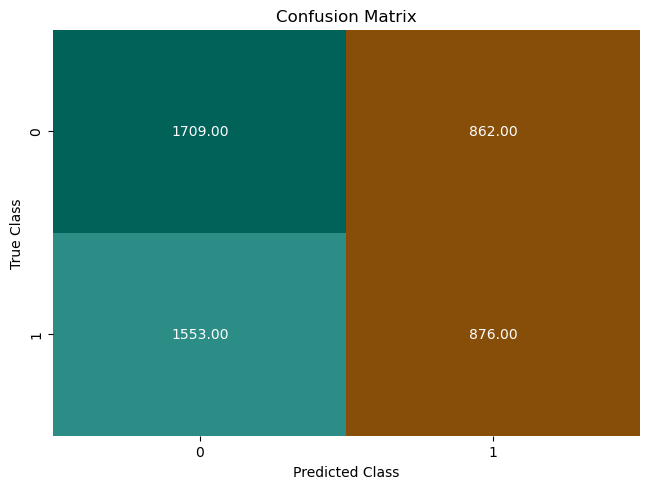

In [39]:
plot_confusion_matrix(test['label'], target_predicted_binary)

In [40]:
print_metrics(test['label'], target_predicted_binary)

Sensitivity or TPR: 36.06422396047756%
Specificity or TNR: 66.47218980941268%
Precision: 50.40276179516686%
Negative Predictive Value: 52.39117106069896%
False Positive Rate: 33.52781019058732%
False Negative Rate: 63.93577603952244%
False Discovery Rate: 49.59723820483315%
Accuracy: 51.7%


Is the new model better or worse than the first model?

## 6. Tuning hyperparameters
([Go to top](#Lab-4.1:-Implementing-Sentiment-Analysis))

In this section, you will create a hyperparameter tuning job to tune the model.

__Note__: Tuning Hyperparameters takes about an hour to complete. If you don't have enough time, proceed to Section 7. You can also skip to section 7 after you start the tuning job, and return to its results later.

### Challenge: Creating the estimator to tune

The first step is to create an estimator to tune. Uncomment and complete the following estimator code:

In [41]:
# xgb = sagemaker.estimator.Estimator(....)
### BEGIN_SOLUTION
xgb = sagemaker.estimator.Estimator(container,
                                    role=sagemaker.get_execution_role(), 
                                    instance_count= 1, # make sure you have limit set for these instances
                                    instance_type='ml.m5.2xlarge', 
                                    output_path=f's3://{bucket}/{prefix}/output',
                                    sagemaker_session=sagemaker.Session())
### END_SOLUTION

In [42]:
xgb.set_hyperparameters(eval_metric='error',
                        objective='binary:logistic',
                        num_round=42,
                        silent=1)

### Challenge: Creating the hyperparameter ranges

Using the [XGBoost Tuning documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost-tuning.html), add hyperparameter ranges to the following cell.



In [43]:
from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner

hyperparameter_ranges = {'alpha': ContinuousParameter(0,1000)}

### BEGIN_SOLUTION
hyperparameter_ranges = {'alpha': ContinuousParameter(0, 1000),
                         'min_child_weight': ContinuousParameter(0, 120),
                         'subsample': ContinuousParameter(0.5, 1),
                         'eta': ContinuousParameter(0.1, 0.5),  
                         'num_round': IntegerParameter(1,4000)
                         }
### END_SOLUTION

### Challenge: Specifying the target metrics

Update the `objective_metric_name` and `objective_type` to appropriate values for a binary classification problem. For more information, see the [XGBoost Tuning documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost-tuning.html).

In [44]:
objective_metric_name = '<INSERT_VALUE_HERE>'
objective_type = '<INSERT_VALUE_HERE>'

### BEGIN_SOLUTION
objective_metric_name = 'validation:error'
objective_type = 'Minimize'
### END_SOLUTION

Create the hyperparameter tuning job.

In [45]:
tuner = HyperparameterTuner(xgb,
                            objective_metric_name,
                            hyperparameter_ranges,
                            max_jobs=10, # Set this to 10 or above depending upon budget & available time.
                            max_parallel_jobs=1,
                            objective_type=objective_type,
                            early_stopping_type='Auto',
                           )

Run the tuning job. Note that this job might take around 60 minutes to complete. 

In [46]:
%%time
tuner.fit(inputs=data_channels, include_cls_metadata=False, wait=False)

INFO:sagemaker:Creating hyperparameter tuning job with name: sagemaker-xgboost-230305-0701


CPU times: user 40 ms, sys: 0 ns, total: 40 ms
Wall time: 698 ms


If you want to try Section 7 while you wait, don't run the next cell and go to Section 7.

In [47]:
tuner.wait()

......................................................................................................................................................................................!


When the tuning job is complete, you can view the metrics from the tuning jobs.

In [48]:
from pprint import pprint
from sagemaker.analytics import HyperparameterTuningJobAnalytics

tuner_analytics = HyperparameterTuningJobAnalytics(tuner.latest_tuning_job.name, sagemaker_session=sagemaker.Session())

df_tuning_job_analytics = tuner_analytics.dataframe()

# Sort the tuning job analytics by the final metrics value
df_tuning_job_analytics.sort_values(
    by=['FinalObjectiveValue'],
    inplace=True,
    ascending=False if tuner.objective_type == "Maximize" else True)

# Show detailed analytics for the top 20 models
df_tuning_job_analytics.head(20)

,alpha,eta,min_child_weight,num_round,subsample,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
0,0.000000,0.500000,27.977852,780.0,0.873409,sagemaker-xgboost-230305-0701-010-cc792014,Completed,0.1582,2023-03-05 07:13:51+00:00,2023-03-05 07:16:34+00:00,163.0
1,0.000000,0.369226,24.421083,217.0,0.636220,sagemaker-xgboost-230305-0701-009-55b0ea17,Completed,0.1592,2023-03-05 07:12:22+00:00,2023-03-05 07:13:34+00:00,72.0
3,136.782979,0.161109,15.730696,393.0,0.684995,sagemaker-xgboost-230305-0701-007-d8580146,Stopped,0.1886,2023-03-05 07:08:39+00:00,2023-03-05 07:09:23+00:00,44.0
6,108.026785,0.143783,88.095452,84.0,0.889349,sagemaker-xgboost-230305-0701-004-15248335,Completed,0.1932,2023-03-05 07:05:52+00:00,2023-03-05 07:06:40+00:00,48.0
9,72.104486,0.157077,4.504351,30.0,0.534055,sagemaker-xgboost-230305-0701-001-ec34e13c,Completed,0.2118,2023-03-05 07:02:27+00:00,2023-03-05 07:03:49+00:00,82.0
7,378.876518,0.200121,38.829342,23.0,0.631434,sagemaker-xgboost-230305-0701-003-1903fce8,Completed,0.2338,2023-03-05 07:05:00+00:00,2023-03-05 07:05:37+00:00,37.0
4,749.924191,0.107359,36.573779,66.0,1.000000,sagemaker-xgboost-230305-0701-006-3e8dc7df,Completed,0.2354,2023-03-05 07:07:42+00:00,2023-03-05 07:08:24+00:00,42.0
8,725.163576,0.246652,80.518062,249.0,0.652594,sagemaker-xgboost-230305-0701-002-df4a23e2,Stopped,0.2410,2023-03-05 07:04:08+00:00,2023-03-05 07:04:53+00:00,45.0
5,240.531668,0.324439,61.433118,5.0,0.846123,sagemaker-xgboost-230305-0701-005-409d5d6c,Completed,0.2552,2023-03-05 07:06:54+00:00,2023-03-05 07:07:26+00:00,32.0
2,150.874983,0.104373,86.963809,4.0,0.833948,sagemaker-xgboost-230305-0701-008-8f37324f,Completed,0.2758,2023-03-05 07:10:34+00:00,2023-03-05 07:11:52+00:00,78.0


## Using the best hyperparameter job

After the tuning job is complete, you can find the best tuning job from the **HyperparameterTuner** object.


In [49]:
attached_tuner = HyperparameterTuner.attach(tuner.latest_tuning_job.name, sagemaker_session=sagemaker.Session())
best_training_job = attached_tuner.best_training_job()

In [50]:
from sagemaker.estimator import Estimator
algo_estimator = Estimator.attach(best_training_job)

best_algo_model = algo_estimator.create_model(env={'SAGEMAKER_DEFAULT_INVOCATIONS_ACCEPT':"text/csv"})


2023-03-05 07:16:36 Starting - Found matching resource for reuse
2023-03-05 07:16:36 Downloading - Downloading input data
2023-03-05 07:16:36 Training - Training image download completed. Training in progress.
2023-03-05 07:16:36 Uploading - Uploading generated training model
2023-03-05 07:16:36 Completed - Resource retained for reuse


Run the test data through the data processing pipeline so that you can test the model.

In [51]:
%%time
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

text_features = ['text']
model_target = 'label'

text_processor_0 = Pipeline([
    ('text_vect_0', CountVectorizer(preprocessor=clean, max_features=500))
])

data_preprocessor = ColumnTransformer([
    ('text_pre_0', text_processor_0, text_features[0])
])

print('Datasets shapes before processing: ', train.shape, validate.shape, test.shape)
train_matrix = data_preprocessor.fit_transform(train)
test_matrix = data_preprocessor.transform(test)
validate_matrix = data_preprocessor.transform(validate)
print('Datasets shapes after processing: ', train_matrix.shape, validate_matrix.shape, test_matrix.shape)

Datasets shapes before processing:  (40000, 2) (5000, 2) (5000, 2)
Datasets shapes after processing:  (40000, 500) (5000, 500) (5000, 500)
CPU times: user 2min 37s, sys: 17.8 ms, total: 2min 37s
Wall time: 2min 37s


Use the test data on a batch transformation by using the best algorithm from the hyperparameter tuning job.

In [52]:
%%time
upload_s3_csv('batch-in.csv', 'batch-in', test_matrix, test, True)

batch_output = f's3://{bucket}/{prefix}/batch-out/'
batch_input = f's3://{bucket}/{prefix}/batch-in/{batch_X_file}'

xgb_transformer = best_algo_model.transformer(instance_count=1,
                                       instance_type='ml.m5.2xlarge',
                                       strategy='MultiRecord',
                                       assemble_with='Line',
                                       output_path=batch_output)
xgb_transformer.transform(data=batch_input,
                         data_type='S3Prefix',
                         content_type='text/csv',
                         split_type='Line')
xgb_transformer.wait(logs=False)

INFO:sagemaker:Creating model with name: sagemaker-xgboost-2023-03-05-07-19-42-502
INFO:sagemaker:Creating transform job with name: sagemaker-xgboost-2023-03-05-07-19-43-080


..............................
[2023-03-05:07:24:31:INFO] No GPUs detected (normal if no gpus installed)
[2023-03-05:07:24:31:INFO] No GPUs detected (normal if no gpus installed)
[2023-03-05:07:24:31:INFO] nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;
worker_rlimit_nofile 4096;
events {
  worker_connections 2048;
}
http {
  include /etc/nginx/mime.types;
  default_type application/octet-stream;
  access_log /dev/stdout combined;
  upstream gunicorn {
    server unix:/tmp/gunicorn.sock;
  }
  server {
    listen 8080 deferred;
    client_max_body_size 0;
    keepalive_timeout 3;
    location ~ ^/(ping|invocations|execution-parameters) {
      proxy_set_header X-Forwarded-For $proxy_add_x_forwarded_for;
      proxy_set_header Host $http_host;
      proxy_redirect off;
      proxy_read_timeout 60s;
      proxy_pass http://gunicorn;
    }
    location / {
      return 404 "{}";
    }
  }
}
[2023-03-05:07:24:31:INFO] No GPUs detected (normal i

Process the results to calculate the class.

In [53]:
s3 = boto3.client('s3')
obj = s3.get_object(Bucket=bucket, Key=f'{prefix}/batch-out/batch-in.csv.out')
target_predicted = pd.read_csv(io.BytesIO(obj['Body'].read()),',',names=['class'])

def binary_convert(x):
    threshold = 0.5
    if x > threshold:
        return 1
    else:
        return 0

target_predicted_binary = target_predicted['class'].apply(binary_convert)


/tmp/ipykernel_20696/251496374.py:3: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only.
  target_predicted = pd.read_csv(io.BytesIO(obj['Body'].read()),',',names=['class'])


Plot the confusion matrix and print the metrics.

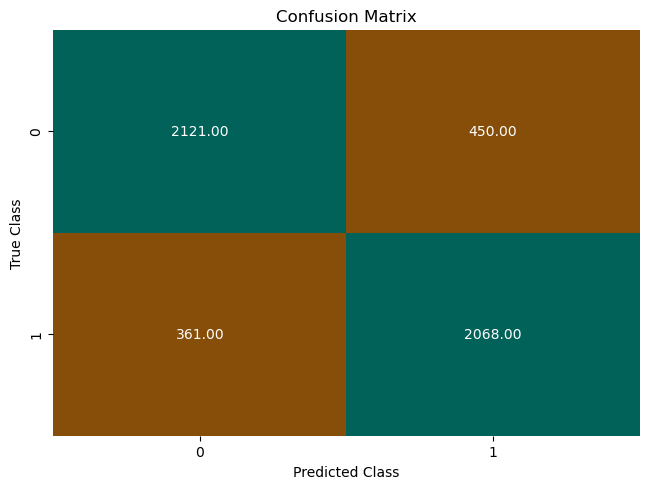

In [54]:
plot_confusion_matrix(test['label'], target_predicted_binary)

In [55]:
print_metrics(test['label'], target_predicted_binary)

Sensitivity or TPR: 85.13791683820502%
Specificity or TNR: 82.49708284714119%
Precision: 82.12867355043686%
Negative Predictive Value: 85.4552780016116%
False Positive Rate: 17.50291715285881%
False Negative Rate: 14.862083161794978%
False Discovery Rate: 17.871326449563146%
Accuracy: 83.78%


## 7. Using BlazingText
([Go to top](#Lab-4.1:-Implementing-Sentiment-Analysis))

In this section, you will use BlazingText, which is a built-in Amazon SageMaker algorithm. BlazingText can perform classification without modifications. You will reformat the data for BlazingText. You will then use the data to train the algorithm and compare the results to the previous models.


Start by obtaining the container for the algorithm.

In [56]:
import sagemaker
from sagemaker.image_uris import retrieve

container = retrieve('blazingtext',boto3.Session().region_name,"latest")

INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.


Configure the prefixes for the training, validation, and test data.

In [57]:
import io
    
prefix='lab41'
train_file='blazing_train.txt'
validate_file='blazing_validate.txt'
test_file='blazing_test.txt'

Remind yourself of what the data looks like.

In [58]:
train.head()

,text,label
29572,Caught this movie on the tube on a Sunday. I t...,0
42816,Seeing as Keifer Sutherland plays my favorite ...,1
15853,"Stan as a bullfighter, and a good one, is quit...",1
38282,Ok so I was bored and I watched it all the way...,0
36321,This can't be Mandy Schaffer's last film. Some...,0



BlazingText needs the data in the following format:

\__label__1 Caught this movie on the tube on a Sunday...

The following two cells convert the dataframes into the correct format, and upload them to Amazon S3.

In [59]:
blazing_text_buffer = io.StringIO()
train.to_string(buf=blazing_text_buffer, columns=['label','text'], header=False, index=False, formatters=
                         {'label': '__label__{}'.format})
s3r = boto3.resource('s3')
s3r.Bucket(bucket).Object(os.path.join(prefix, 'blazing', train_file)).put(Body=blazing_text_buffer.getvalue())

{'ResponseMetadata': {'RequestId': 'JZRYHG5C8YYWXQ6P',
  'HostId': '3hLIWutkWjZyGzOai8WuUg+918liSF8I0r44iZWNOrYn0xJMVBrD1KrK6qGq1nUq1hJzcS/bxBE=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': '3hLIWutkWjZyGzOai8WuUg+918liSF8I0r44iZWNOrYn0xJMVBrD1KrK6qGq1nUq1hJzcS/bxBE=',
   'x-amz-request-id': 'JZRYHG5C8YYWXQ6P',
   'date': 'Sun, 05 Mar 2023 07:25:08 GMT',
   'x-amz-server-side-encryption': 'AES256',
   'etag': '"d2cbe833d8eace19960f9eeb3939980a"',
   'server': 'AmazonS3',
   'content-length': '0'},
  'RetryAttempts': 0},
 'ETag': '"d2cbe833d8eace19960f9eeb3939980a"',
 'ServerSideEncryption': 'AES256'}

In [60]:
blazing_text_buffer = io.StringIO()
validate.to_string(buf=blazing_text_buffer, columns=['label','text'], header=False, index=False, formatters=
                         {'label': '__label__{}'.format})
s3r.Bucket(bucket).Object(os.path.join(prefix, 'blazing', validate_file)).put(Body=blazing_text_buffer.getvalue())

{'ResponseMetadata': {'RequestId': '85XZYH4VTR5PEMCC',
  'HostId': 'olNBzDvjx0MzZ/SvVZi7g4g+v0lz80oIlUTIozgKRnUrfBt+eO7SxaNqp2uRZVhqDMiwamkvL6c=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'olNBzDvjx0MzZ/SvVZi7g4g+v0lz80oIlUTIozgKRnUrfBt+eO7SxaNqp2uRZVhqDMiwamkvL6c=',
   'x-amz-request-id': '85XZYH4VTR5PEMCC',
   'date': 'Sun, 05 Mar 2023 07:25:11 GMT',
   'x-amz-server-side-encryption': 'AES256',
   'etag': '"454e6e28ce395eb3c0ec56e8a5755f20"',
   'server': 'AmazonS3',
   'content-length': '0'},
  'RetryAttempts': 0},
 'ETag': '"454e6e28ce395eb3c0ec56e8a5755f20"',
 'ServerSideEncryption': 'AES256'}

### Challenge: Training the BlazingText estimator

In the next cell, uncomment and complete the estimator code by specifying the missing values. 



In [61]:
# bt_model = sagemaker.estimator.Estimator(container,
#                                         sagemaker.get_execution_role(), 
#                                         instance_count=, 
#                                         instance_type=,
#                                         volume_size = 30,
#                                         max_run = 360000,
#                                         input_mode= 'File',
#                                         output_path=,
#                                         sagemaker_session=

### BEGIN_SOLUTION
bt_model = sagemaker.estimator.Estimator(container,
                                         sagemaker.get_execution_role(), 
                                         instance_count=1, 
                                         instance_type='ml.c4.4xlarge',
                                         volume_size = 30,
                                         max_run = 360000,
                                         input_mode= 'File',
                                         output_path=s3_output_location,
                                         sagemaker_session=sagemaker.Session())

### END_SOLUTION

Use the following hyperparameters:

In [62]:
bt_model.set_hyperparameters(mode="supervised",
                            epochs=10,
                            min_count=2,
                            learning_rate=0.05,
                            vector_dim=10,
                            early_stopping=True,
                            patience=4,
                            min_epochs=5,
                            word_ngrams=2)

Set up the training channel and the validate channel.

In [63]:
train_channel = sagemaker.inputs.TrainingInput(
    f's3://{bucket}/{prefix}/blazing/{train_file}',
    content_type='text/csv')

validate_channel = sagemaker.inputs.TrainingInput(
    f's3://{bucket}/{prefix}/blazing/{validate_file}',
    content_type='text/csv')

data_channels_3 = {'train': train_channel, 'validation': validate_channel}

### Challenge: Starting the training job

Start the training job by entering the following code. (This step might take a few minutes.)

In [64]:
%%time

### BEGIN_SOLUTION
bt_model.fit(inputs=data_channels_3, logs=False)
### END_SOLUTION

INFO:sagemaker:Creating training-job with name: blazingtext-2023-03-05-07-25-10-823



2023-03-05 07:25:11 Starting - Starting the training job....
2023-03-05 07:25:36 Starting - Preparing the instances for training.......
2023-03-05 07:26:21 Downloading - Downloading input data......
2023-03-05 07:26:56 Training - Training image download completed. Training in progress.....
2023-03-05 07:27:21 Uploading - Uploading generated training model...
2023-03-05 07:27:42 Completed - Training job completed
CPU times: user 138 ms, sys: 4.33 ms, total: 143 ms
Wall time: 2min 31s


After the training job is complete, view the training metrics.

In [65]:
sagemaker.analytics.TrainingJobAnalytics(bt_model._current_job_name, 
                                         metric_names = ['train:accuracy','validation:accuracy']
                                        ).dataframe()

,timestamp,metric_name,value
0,0.0,train:accuracy,0.9134
1,0.0,validation:accuracy,0.8720


In [66]:
pd.options.display.max_rows
pd.set_option('display.max_colwidth', None)

Make a copy of the test data so that it can be formatted to use the model.

In [67]:
bt_test = test.copy()
bt_test.head()

,text,label
16591,"This is a charming movie starring everyone's favorite cartoon chipmunks. In this feature we follow the band of rodents on an unforgettable balloon race around the world. Although there are lows, including an orphan penguin, all in all it's a great family film.",1
21931,"I really should have learned more about this movie before renting it. It was one of those movies where you keep watching it figuring it's got to get better. Then, when it ends, you feel stupid for having wasted precious time in your life that you can never get back. Ice-T did his bad guy thing and, well, that was the highlight of the evening. The pictures of the shuttle looks like it was done with a little toy inside of a box and the spacewalking scenes were funny because you could see the strings attached to the space suits. The script was lacking and the car chase scene with the guy bleeding and going unconscious was incredible because he drove better than I could have on one of my best days. All in all, I have seen worse but this sure isn't one I'd recommend or want to remember.",0
22143,"There have been several comments already on the site focusing on the ""prestige"" feel of the film - and there is a lot of heavy-weight talent on show: from Fiennes and Scott-Thomas to the magnificently rendered design and scoring, to the masterly direction. No wonder that Andrew Lloyd Webber's acceptance speech for ""Evita"" at that year's Oscars began ""Well, thank God that ""The English Patient"" had no songs in it."" Writing of Oscar winners takes me to Juliette Binoche, who, in a stellar cast, gives a beautiful performance. It is heartening to see that the dynamics which seem to influence the award for Best Actor (often going to showy pyrotechnic display) aren't at work in the female categories. Just as Emma Thompson's hugely well-deserved Oscar for her portrayal of Margaret Schlegel in ""Howard's End"" proved that one of the hardest things that an actor can do is make the portrayal of ""goodness"" involving, so Binoche's win proved that it could be that - and seriously sexy. Her performance in this terrific film is a thing of beauty.",1
1133,"My wife and I struggle to find movies like this that are clean and yet enjoyable for adults. If you can't find a cinema that is playing it, call your cinema and request it. Bravo, Five Sisters Productions for courage, tenacity and creative endeavor!",1
10413,"Basil Rathbone and Nigel Bruce return as Sherlock Holmes and Dr. Watson in this superior tale of Holmes battling the 3rd Reich and the mastermind genius of Professor Moriarty. The film opens up in Switzerland as Holmes is in disguise as an ""old bookseller."" He must bring Dr. Tobel and the Tobel Bomb Site to England before the Germans can kidnap Tobel. Holmes succeeds and the Germans recuit the evil Professor. Moriarty manages to outwit Scotland yard and LeStrad ""Dennis Hoey"" by kidnapping Tobel. The only clue left by Tobel is a list of ""dancing men."" Who will break the hidden code of dancing men, Holmes or Moriarty first? Can Holmes prevent the bomb site from falling into the German hands thereby saving England from the precision bombing techniques developed by Tobel's bomb site? Watch and enjoy.",1


Format the dataset into the format that BlazingText needs.

In [68]:
# bt_test['text'].str.strip()
bt_test.replace(r'\\n','', regex=True, inplace = True)
bt_test.rename(columns={'text':'source'}, inplace=True)
bt_test.drop(columns='label', inplace=True)

In [69]:
print(bt_test.head().to_json(orient="records", lines=True))

{"source":"This is a charming movie starring everyone's favorite cartoon chipmunks. In this feature we follow the band of rodents on an unforgettable balloon race around the world. Although there are lows, including an orphan penguin, all in all it's a great family film."}
{"source":"I really should have learned more about this movie before renting it. It was one of those movies where you keep watching it figuring it's got to get better. Then, when it ends, you feel stupid for having wasted precious time in your life that you can never get back. Ice-T did his bad guy thing and, well, that was the highlight of the evening. The pictures of the shuttle looks like it was done with a little toy inside of a box and the spacewalking scenes were funny because you could see the strings attached to the space suits. The script was lacking and the car chase scene with the guy bleeding and going unconscious was incredible because he drove better than I could have on one of my best days. All in all,

Upload the file to Amazon S3.

In [70]:
bt_file = 'bt_input.json'
blazing_text_buffer = io.StringIO()
bt_test.to_json(path_or_buf=blazing_text_buffer, orient="records", lines=True)

In [71]:
s3r.Bucket(bucket).Object(os.path.join(prefix, 'blazing', bt_file)).put(Body=blazing_text_buffer.getvalue())


{'ResponseMetadata': {'RequestId': 'NXJ23NBFD1NQJ7WE',
  'HostId': 'dGS1UEQRMn9CAQczWYKkVyInne5jDWBUhlEB7CegYp6t21Ri0+rlkh7f/vnBFhygRN8Frj/N34A=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'dGS1UEQRMn9CAQczWYKkVyInne5jDWBUhlEB7CegYp6t21Ri0+rlkh7f/vnBFhygRN8Frj/N34A=',
   'x-amz-request-id': 'NXJ23NBFD1NQJ7WE',
   'date': 'Sun, 05 Mar 2023 07:27:43 GMT',
   'x-amz-server-side-encryption': 'AES256',
   'etag': '"38b2ee8737428c6d3f47a6a861556d6f"',
   'server': 'AmazonS3',
   'content-length': '0'},
  'RetryAttempts': 0},
 'ETag': '"38b2ee8737428c6d3f47a6a861556d6f"',
 'ServerSideEncryption': 'AES256'}

In [72]:
batch_output = f's3://{bucket}/{prefix}/blazing/'
batch_input = f's3://{bucket}/{prefix}/blazing/{bt_file}'

Use a batch transformer on the test data. (This step might take a few minutes.)

In [73]:
%%time
bt_transformer = bt_model.transformer(instance_count=1,
                                       instance_type='ml.m5.2xlarge',
                                       strategy='MultiRecord',
                                       assemble_with='Line',
                                       output_path=batch_output)

bt_transformer.transform(data=batch_input,
                         data_type='S3Prefix',
                         content_type='application/jsonlines',
                         split_type='Line')

bt_transformer.wait(logs=True)

INFO:sagemaker:Creating model with name: blazingtext-2023-03-05-07-27-43-031
INFO:sagemaker:Creating transform job with name: blazingtext-2023-03-05-07-27-43-606


........................
Arguments: serve
[03/05/2023 07:31:28 INFO 140177420474176] Finding and loading model
[03/05/2023 07:31:28 INFO 140177420474176] Trying to load model from /opt/ml/model/model.bin
[03/05/2023 07:31:28 INFO 140177420474176] Number of server workers: 8
[2023-03-05 07:31:28 +0000] [1] [INFO] Starting gunicorn 19.7.1
Arguments: serve
[03/05/2023 07:31:28 INFO 140177420474176] Finding and loading model
[03/05/2023 07:31:28 INFO 140177420474176] Trying to load model from /opt/ml/model/model.bin
[03/05/2023 07:31:28 INFO 140177420474176] Number of server workers: 8
[2023-03-05 07:31:28 +0000] [1] [INFO] Starting gunicorn 19.7.1
[2023-03-05 07:31:28 +0000] [1] [INFO] Listening at: http://0.0.0.0:8080 (1)
[2023-03-05 07:31:28 +0000] [1] [INFO] Using worker: sync
[2023-03-05 07:31:28 +0000] [38] [INFO] Booting worker with pid: 38
[2023-03-05 07:31:28 +0000] [39] [INFO] Booting worker with pid: 39
[2023-03-05 07:31:28 +0000] [40] [INFO] Booting worker with pid: 40
[2023-03

Retrieve the results from Amazon S3.

In [74]:
obj = s3.get_object(Bucket=bucket, Key=f'{prefix}/blazing/bt_input.json.out')

In [75]:
target_predicted = pd.read_json(io.BytesIO(obj['Body'].read()),lines=True)

In [76]:
target_predicted.head()

,label,prob
0,[__label__1],[0.999834954738616]
1,[__label__0],[0.8825576901435851]
2,[__label__1],[0.863244771957397]
3,[__label__1],[0.97547435760498]
4,[__label__1],[0.780409157276153]


Reformat the results so that you can calculate the confusion matrix and the metrics.

In [77]:
def binary_convert(label):
    label = label[0].replace('__label__','')
    return int(label)

target_predicted_binary = target_predicted['label'].apply(binary_convert)

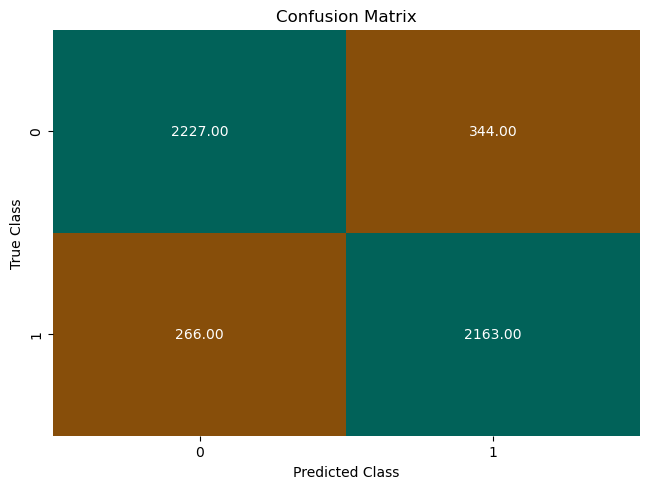

In [78]:
plot_confusion_matrix(test['label'], target_predicted_binary)

In [79]:
print_metrics(test['label'], target_predicted_binary)

Sensitivity or TPR: 89.04899135446685%
Specificity or TNR: 86.61999222092571%
Precision: 86.27842042281611%
Negative Predictive Value: 89.33012434817489%
False Positive Rate: 13.38000777907429%
False Negative Rate: 10.951008645533141%
False Discovery Rate: 13.721579577183885%
Accuracy: 87.8%


How did BlazingText perform compared to the previous models?

## 8. Using Amazon Comprehend
([Go to top](#Lab-4.1:-Implementing-Sentiment-Analysis))

In this section, you will use Amazon Comprehend to calculate the sentiment. Amazon Comprehend gives you positive and negative results, and it also shows neutral and mixed results. Amazon Comprehend is a managed service, and it requires less text processing before it's used. You won't need to process any text in this section.

Review what the data looks like in the `test` dataframe.

In [80]:
test.head()

,text,label
16591,"This is a charming movie starring everyone's favorite cartoon chipmunks. In this feature we follow the band of rodents on an unforgettable balloon race around the world. Although there are lows, including an orphan penguin, all in all it's a great family film.",1
21931,"I really should have learned more about this movie before renting it. It was one of those movies where you keep watching it figuring it's got to get better. Then, when it ends, you feel stupid for having wasted precious time in your life that you can never get back. Ice-T did his bad guy thing and, well, that was the highlight of the evening. The pictures of the shuttle looks like it was done with a little toy inside of a box and the spacewalking scenes were funny because you could see the strings attached to the space suits. The script was lacking and the car chase scene with the guy bleeding and going unconscious was incredible because he drove better than I could have on one of my best days. All in all, I have seen worse but this sure isn't one I'd recommend or want to remember.",0
22143,"There have been several comments already on the site focusing on the ""prestige"" feel of the film - and there is a lot of heavy-weight talent on show: from Fiennes and Scott-Thomas to the magnificently rendered design and scoring, to the masterly direction. No wonder that Andrew Lloyd Webber's acceptance speech for ""Evita"" at that year's Oscars began ""Well, thank God that ""The English Patient"" had no songs in it."" Writing of Oscar winners takes me to Juliette Binoche, who, in a stellar cast, gives a beautiful performance. It is heartening to see that the dynamics which seem to influence the award for Best Actor (often going to showy pyrotechnic display) aren't at work in the female categories. Just as Emma Thompson's hugely well-deserved Oscar for her portrayal of Margaret Schlegel in ""Howard's End"" proved that one of the hardest things that an actor can do is make the portrayal of ""goodness"" involving, so Binoche's win proved that it could be that - and seriously sexy. Her performance in this terrific film is a thing of beauty.",1
1133,"My wife and I struggle to find movies like this that are clean and yet enjoyable for adults. If you can't find a cinema that is playing it, call your cinema and request it. Bravo, Five Sisters Productions for courage, tenacity and creative endeavor!",1
10413,"Basil Rathbone and Nigel Bruce return as Sherlock Holmes and Dr. Watson in this superior tale of Holmes battling the 3rd Reich and the mastermind genius of Professor Moriarty. The film opens up in Switzerland as Holmes is in disguise as an ""old bookseller."" He must bring Dr. Tobel and the Tobel Bomb Site to England before the Germans can kidnap Tobel. Holmes succeeds and the Germans recuit the evil Professor. Moriarty manages to outwit Scotland yard and LeStrad ""Dennis Hoey"" by kidnapping Tobel. The only clue left by Tobel is a list of ""dancing men."" Who will break the hidden code of dancing men, Holmes or Moriarty first? Can Holmes prevent the bomb site from falling into the German hands thereby saving England from the precision bombing techniques developed by Tobel's bomb site? Watch and enjoy.",1


Using Amazon Comprehend can be as straightforward as making an API call.

The following cell outputs the first five results from Amazon Comprehend.

In [81]:
import boto3
import json

comprehend = boto3.client(service_name='comprehend')
for n in range(5):
    text = test.iloc[n]['text']
    response = comprehend.detect_sentiment(Text=text, LanguageCode='en')
    sentiment = response['Sentiment']
    print(f'{sentiment} - {text}')


POSITIVE - This is a charming movie starring everyone's favorite cartoon chipmunks. In this feature we follow the band of rodents on an unforgettable balloon race around the world. Although there are lows, including an orphan penguin, all in all it's a great family film.
NEGATIVE - I really should have learned more about this movie before renting it. It was one of those movies where you keep watching it figuring it's got to get better. Then, when it ends, you feel stupid for having wasted precious time in your life that you can never get back. Ice-T did his bad guy thing and, well, that was the highlight of the evening. The pictures of the shuttle looks like it was done with a little toy inside of a box and the spacewalking scenes were funny because you could see the strings attached to the space suits. The script was lacking and the car chase scene with the guy bleeding and going unconscious was incredible because he drove better than I could have on one of my best days. All in all, I

You can start a prediction job to process multiple items. The input must be formatted as a single input per line, and uploaded to Amazon S3. The text has a maximum size of 5120, so the `str.slice(0,5000)` function is used to trim long text.

In [82]:
# Upload test file minus label to S3
def upload_comprehend_s3_csv(filename, folder, dataframe):
    csv_buffer = io.StringIO()
    
    dataframe.to_csv(csv_buffer, header=False, index=False )
    s3_resource.Bucket(bucket).Object(os.path.join(prefix, folder, filename)).put(Body=csv_buffer.getvalue())

comprehend_file = 'comprehend_input.csv'
upload_comprehend_s3_csv(comprehend_file, 'comprehend', test['text'].str.slice(0,5000))
test_url = f's3://{bucket}/{prefix}/comprehend/{comprehend_file}'
print(f'Uploaded input to {test_url}')

Uploaded input to s3://c73485a1491087l3681508t1w420634201050-labbucket-gh2i9k2ayp1/lab41/comprehend/comprehend_input.csv


When the data is uploaded to Amazon S3, you start the job by using the `start_sentiment_detection_jon` function. 



### Challenge: Configuring the Amazon Comprehend job parameters

In the next cell, configure the Amazon Comprehend job parameters. 
- In __input_data_config__ - 
  - **S3Uri**: Replace *`<S3_INPUT_GOES_HERE>`* with the `test_uri` that was defined previously
  - **InputFormat**: Replace *`<INPUT_FORMAT_GOES_HERE>`* with `ONE_DOC_PER_LINE`
- In __output_data-config__ -  
  - **S3Uri**: Replace *`<S3_OUTPUT_GOES_HERE>`*  with the `s3_output_location`
  - **data_access_role_arn**: Replace *`data_acess_role_arn`* with the Amazon Resource Name (ARN) of the IAM Role ComprehendDataAccessRole.  To get the role, ARN go to the IAM console and choose Roles in the left navigation menu.  You will see all roles listed and from there you can find ComprehendDataAccessRole.  Choose that role, and copy the ARN.

In [83]:
input_data_config={
    'S3Uri': 'S3_INPUT_GOES_HERE',
    'InputFormat': 'INPUT_FORMAT_GOES_HERE'
},

output_data_config={
    'S3Uri': 'S3_OUTPUT_GOES_HERE'
},
data_access_role_arn = 'arn:aws:iam::420634201050:role/service-role/c73485a1491087l3681508t1w-ComprehendDataAccessRole-6I3AFMHRPU23'

### BEGIN_SOLUTION
input_data_config={
    'S3Uri': test_url,
    'InputFormat': 'ONE_DOC_PER_LINE'
}
output_data_config={
    'S3Uri': s3_output_location
}
data_access_role_arn = 'arn:aws:iam::420634201050:role/service-role/c73485a1491087l3681508t1w-ComprehendDataAccessRole-6I3AFMHRPU23'
### END_SOLUTION

Now that you defined the job parameters, start the sentiment detection job.

In [84]:
response = comprehend.start_sentiment_detection_job(
    InputDataConfig=input_data_config,
    OutputDataConfig=output_data_config,
    DataAccessRoleArn=data_access_role_arn,
    JobName='movie_sentiment',
    LanguageCode='en'
)

print(response['JobStatus'])

SUBMITTED


The following cell will loop until the job is completed. (This step might take a few minutes to complete.)

In [85]:
%%time
import time
job_id = response['JobId']
while True:
    job_status=(comprehend.describe_sentiment_detection_job(JobId=job_id))
    if job_status['SentimentDetectionJobProperties']['JobStatus'] in ['COMPLETED','FAILED']:
        break            
    else:
        print('.', end='')
    time.sleep(15)
print((comprehend.describe_sentiment_detection_job(JobId=job_id))['SentimentDetectionJobProperties']['JobStatus'])

.................................COMPLETED
CPU times: user 1.19 s, sys: 28.4 ms, total: 1.22 s
Wall time: 8min 18s


When the job is complete, you can return the details from the job by calling the `describe_sentiment_detection_job` function.

In [86]:
output=(comprehend.describe_sentiment_detection_job(JobId=job_id))
print(output)

{'SentimentDetectionJobProperties': {'JobId': '3e3de179ea1f9f2a11260e327b4376a1', 'JobArn': 'arn:aws:comprehend:us-east-1:420634201050:sentiment-detection-job/3e3de179ea1f9f2a11260e327b4376a1', 'JobName': 'movie_sentiment', 'JobStatus': 'COMPLETED', 'SubmitTime': datetime.datetime(2023, 3, 5, 7, 32, 3, 461000, tzinfo=tzlocal()), 'EndTime': datetime.datetime(2023, 3, 5, 7, 40, 12, 111000, tzinfo=tzlocal()), 'InputDataConfig': {'S3Uri': 's3://c73485a1491087l3681508t1w420634201050-labbucket-gh2i9k2ayp1/lab41/comprehend/comprehend_input.csv', 'InputFormat': 'ONE_DOC_PER_LINE'}, 'OutputDataConfig': {'S3Uri': 's3://c73485a1491087l3681508t1w420634201050-labbucket-gh2i9k2ayp1/lab41/output/420634201050-SENTIMENT-3e3de179ea1f9f2a11260e327b4376a1/output/output.tar.gz'}, 'LanguageCode': 'en', 'DataAccessRoleArn': 'arn:aws:iam::420634201050:role/service-role/c73485a1491087l3681508t1w-ComprehendDataAccessRole-6I3AFMHRPU23'}, 'ResponseMetadata': {'RequestId': 'bc4d47bc-ad16-4dce-bb29-4f2d4a8cd7a0', '

In the **OutputDataConfig** section, you should see the `S3Uri`. Extracting that URI will give you the file that you must download from Amazon S3. You can use the results to calculate metrics in the same way that you calculated the results from a batch transformation by using an algorithm.

In [87]:
comprehend_output_file = output['SentimentDetectionJobProperties']['OutputDataConfig']['S3Uri']
comprehend_bucket, comprehend_key = comprehend_output_file.replace("s3://", "").split("/", 1)

s3r = boto3.resource('s3')
s3r.meta.client.download_file(comprehend_bucket, comprehend_key, 'output.tar.gz')

# Extract the tar file
import tarfile
tf = tarfile.open('output.tar.gz')
tf.extractall()

The extracted file should be named __output__. Read the the lines in this file.

In [88]:
import json
data = ''
with open ('output', "r") as myfile:
    data = myfile.readlines()

Add the lines to an array.

In [89]:
results = []
for line in data:
    json_data = json.loads(line)
    results.append([json_data['Line'],json_data['Sentiment']])

Convert the array to a pandas dataframe. 

In [95]:
c = pd.DataFrame.from_records(results, index='index', columns=['index','sentiment'])
c.head()

,sentiment
index,
1,NEGATIVE
2,POSITIVE
4,NEUTRAL
6,NEGATIVE
7,POSITIVE


The results contain **NEGATIVE**, **POSITIVE**, **NEUTRAL**, and **MIXED** results instead of numerical values. To compare these results to your test data, they can be mapped to numerical values, as shown in the following cell. The index in the returned results is also out of order. The `sort_index` function should fix this issue.

In [91]:
class_mapper = {'NEGATIVE':0, 'POSITIVE':1, 'NEUTRAL':2, 'MIXED':3}
c['sentiment']=c['sentiment'].replace(class_mapper)
c = c.sort_index()
c.head()

,sentiment
index,
0,1
1,0
2,1
3,1
4,2


In [92]:
# Build list to compare for Amazon Comprehend
test_2 = test.reset_index()
test_3 = test_2.sort_index()
test_labels = test_3.iloc[:,2]

You can display a confusion matrix by using the `plot_confusion_matrix` function. Because Amazon Comprehend also includes __mixed__ and __neutral__ in the results, the chart will be different.

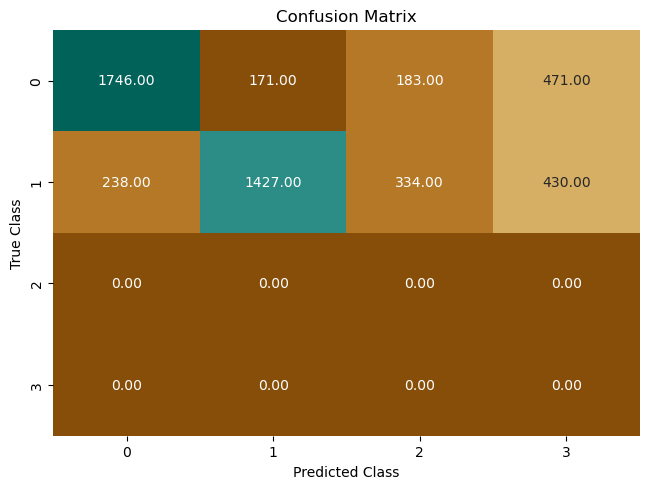

In [93]:
plot_confusion_matrix(test_labels, c['sentiment'])

The existing function to print metrics won't work because you have too many data dimensions. The following code cell will calculate the same values.

In [94]:
cm = confusion_matrix(test_labels, c['sentiment'])

TN = cm[0,0]
FP = cm[0,1]
FN = cm[1,0]
TP = cm[1,1]

Sensitivity  = float(TP)/(TP+FN)*100
# Specificity or true negative rate
Specificity  = float(TN)/(TN+FP)*100
# Precision or positive predictive value
Precision = float(TP)/(TP+FP)*100
# Negative predictive value
NPV = float(TN)/(TN+FN)*100
# Fall out or false positive rate
FPR = float(FP)/(FP+TN)*100
# False negative rate
FNR = float(FN)/(TP+FN)*100
# False discovery rate
FDR = float(FP)/(TP+FP)*100
# Overall accuracy
ACC = float(TP+TN)/(TP+FP+FN+TN)*100

print(f"Sensitivity or TPR: {Sensitivity}%")    
print(f"Specificity or TNR: {Specificity}%") 
print(f"Precision: {Precision}%")   
print(f"Negative Predictive Value: {NPV}%")  
print( f"False Positive Rate: {FPR}%") 
print(f"False Negative Rate: {FNR}%")  
print(f"False Discovery Rate: {FDR}%" )
print(f"Accuracy: {ACC}%") 

Sensitivity or TPR: 85.7057057057057%
Specificity or TNR: 91.07981220657277%
Precision: 89.2991239048811%
Negative Predictive Value: 88.00403225806451%
False Positive Rate: 8.92018779342723%
False Negative Rate: 14.294294294294293%
False Discovery Rate: 10.700876095118899%
Accuracy: 88.58179787828028%


# Congratulations!

You have completed this lab, and you can now end the lab by following the lab guide instructions.

*©2023 Amazon Web Services, Inc. or its affiliates. All rights reserved. This work may not be reproduced or redistributed, in whole or in part, without prior written permission from Amazon Web Services, Inc. Commercial copying, lending, or selling is prohibited. All trademarks are the property of their owners.*
